In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
# Load used training data

filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_493_m_0_sm_n_t_20200206_193734.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8630 entries, 2016-01-01 23:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
day_of_week               8630 non-null int64
day_hour                  8630 non-null int64
dew_temperature_ma_24H    8630 non-null float64
dew_temperature           8630 non-null float64
air_temperature_ma_24H    8630 non-null float64
air_temperature           8630 non-null float64
meter_reading             8630 non-null float64
dtypes: float64(5), int64(2)
memory usage: 539.4 KB


In [18]:
# Build a copy of the train dataset but with 'full index', 
# ie index containing all the hours of the year 2016.

full_date_range = pd.date_range(start='2016-01-01 00:00:00', end='2016-12-31 23:00:00', freq='H')
full_index = pd.DatetimeIndex(full_date_range)

df_full = pd.DataFrame(index=full_index)
for col_name in df_features.columns:
    df_full[col_name] = df_features[col_name]
    
df_full.head(30)

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,meter_reading
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_to_draw['day_hour'] = data_to_draw.index.to_series().dt.hour
data_to_draw['day_of_week'] = data_to_draw.index.to_series().dt.dayofweek
data_to_draw['week_of_year'] = data_to_draw.index.to_series().dt.week.mod(53)

In [49]:
df_w1 = data_to_draw[data_to_draw['week_of_year']==1][['day_of_week', 'day_hour', 'meter_reading']].copy()
df_w1.reset_index(drop=True, inplace=True)
#df_w1.set_index(['day_of_week'], inplace=True)
df_w1_piv = df_w1.pivot(index='day_of_week', columns='day_hour', values='meter_reading')
df_w1_piv.head()

day_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,301.26,299.13,298.92,297.51,296.94,298.62,400.95,590.88,614.31,564.12,...,370.98,439.29,500.52,501.75,510.54,510.75,496.44,514.89,475.29,332.37
1,308.97,308.61,425.10,428.76,421.41,433.83,467.22,649.35,684.60,645.54,...,455.25,509.40,557.61,552.18,555.12,562.26,495.42,474.27,471.54,299.07
2,276.81,273.54,273.03,272.73,281.94,287.19,385.92,604.11,683.43,598.29,...,381.12,432.51,483.39,475.68,496.35,492.54,441.66,442.14,409.95,281.94
3,247.74,249.96,260.31,259.08,258.51,263.58,286.95,526.89,608.79,570.27,...,461.97,466.62,473.34,489.33,476.43,464.49,401.61,357.03,379.08,283.05
4,245.76,245.49,250.89,248.01,249.96,249.51,275.13,529.47,589.14,547.14,...,481.44,525.75,509.61,462.75,478.11,463.83,426.06,412.65,388.92,288.72


In [55]:
np.nan

nan

In [56]:
df_w1_piv.iloc[3, 3] = np.nan

In [57]:
df_w1_piv.head()

day_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,301.26,299.13,298.92,297.51,296.94,298.62,400.95,590.88,614.31,564.12,...,370.98,439.29,500.52,501.75,510.54,510.75,496.44,514.89,475.29,332.37
1,308.97,308.61,425.10,428.76,421.41,433.83,467.22,649.35,684.60,645.54,...,455.25,509.40,557.61,552.18,555.12,562.26,495.42,474.27,471.54,299.07
2,276.81,273.54,273.03,272.73,281.94,287.19,385.92,604.11,683.43,598.29,...,381.12,432.51,483.39,475.68,496.35,492.54,441.66,442.14,409.95,281.94
3,247.74,249.96,260.31,NaN,258.51,263.58,286.95,526.89,608.79,570.27,...,461.97,466.62,473.34,489.33,476.43,464.49,401.61,357.03,379.08,283.05
4,245.76,245.49,250.89,248.01,249.96,249.51,275.13,529.47,589.14,547.14,...,481.44,525.75,509.61,462.75,478.11,463.83,426.06,412.65,388.92,288.72


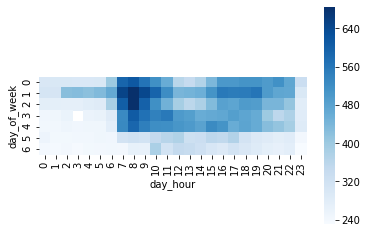

In [60]:
sns.heatmap(df_w1_piv, cmap='Blues', square=True)